In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from planet import tools
import functools
import os
import sys
from scipy import stats
from collections import OrderedDict
import seaborn as sns
import multiprocessing
import time
import pandas as pd
%matplotlib inline
PALETTE = 10 * (
    '#377eb8', '#4daf4a', '#984ea3', '#e41a1c', '#ff7f00', '#a65628',
    '#f781bf', '#888888', '#a6cee3', '#b2df8a', '#cab2d6', '#fb9a99',
    '#fdbf6f')

/home/zixuanhu/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zixuanhu/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zixuanhu/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zixuanhu/anaconda3/envs/tf1/lib/python3.6/s


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# data=np.load('benchmark/finger_spin/aug7/003/onrival.npy')
# base = 'baseline3'
# rival = 'aug7'
# PALETTE = 10 * (
#     '#377eb8', '#4daf4a', '#984ea3', '#e41a1c', '#ff7f00', '#a65628',
#     '#f781bf', '#888888', '#a6cee3', '#b2df8a', '#cab2d6', '#fb9a99',
#     '#fdbf6f')

In [3]:
# data=np.load('benchmark/finger_spin/aug7/003/onrival.npy')
# base = 'baseline3'
# rival = 'aug7'
# buffers = OrderedDict()
# buffers[base] = data[:,:,:,:2].copy()
# buffers[rival] = data[:,:, :,[0,2]].copy()
# for k,v in buffers.items():
#     print(k, v.shape)

In [4]:
def upper_tri_masking(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:, None] < r
    return A[mask]

def stratify_by_iter2(trajs, part_s=3):
    num_parts = int(np.ceil(10 / part_s))
    itr = np.arange(10)
    batch = {}
    prev = np.zeros_like(itr)
    for i in range(num_parts):
        select = (itr < (i + 1) * part_s).astype(int)
        pure_select = select - prev
        batch['{}'.format(i * part_s)] = trajs[:,pure_select.astype(bool),:].squeeze(1)
        prev = select
    return batch

def stratify_by_iter(trajs, part_s=3):
    num_parts = int(np.ceil(10 / part_s))
    num_iters = trajs.shape[0]
    itr = np.arange(num_iters) % 10
    batch = {}
    prev = np.zeros_like(itr)
    print(trajs.shape)
    for i in range(num_parts):
        select = (itr < (i + 1) * part_s).astype(int)
        pure_select = select - prev
        batch['{}'.format(i * part_s)] = trajs[pure_select.astype(bool)]
        prev = select
    for k,v in batch:
        print(k,v.shape)
    return batch


def data_stats(data, name):
    return [np.nanmean(data), np.nanstd(data)]

def ranking_full(gt_sort_ind, pred_sort_ind):
    counter=0
    within_gd=np.zeros_like(gt_sort_ind)
    within_pred=np.zeros_like(gt_sort_ind)
    l = gt_sort_ind.shape[0]
    results = []
    for i, (gd, pred) in enumerate(zip(gt_sort_ind, pred_sort_ind)):
        if gd==pred:
            counter+=1
        else:
            if within_pred[gd]==1:
                counter+=1
            if within_gd[pred]==1:
                counter+=1
        within_gd[gd]=1
        within_pred[pred]=1
        results.append(counter/(i+1)*100)
    return np.array(results)

In [5]:
metrics = ['acc_topk', 'gtRank_by_pred', 'predRank_by_gt','score_gt', 'score_pred', 'mean_ratio', 'rela_acc_all', 'cstr_acc_all', 'rank_loss_all', 
           'rela_acc_lowm', 'cstr_acc_lowm', 'rank_loss_lowm','rela_acc_midm', 'cstr_acc_midm', 'rank_loss_midm', 'rela_acc_highr', 'cstr_acc_highr', 'rank_loss_highr',
          'rela_acc_lowr', 'cstr_acc_lowr', 'rank_loss_lowr','traj_return_gt','traj_return_pred']

def upper_tri_masking(A):
    m,n = A.shape[:2]
    r = np.arange(m)
    c = np.arange(n)
    mask = r[:, None] < c
#     print(r, mask)
    return A[mask]

def get_rela_acc(gt1, pred1, gt2=None, pred2=None, margin_stra=False):
    gt1, pred1 = gt1.reshape(-1, 1), pred1.reshape(-1, 1)
    gt_diff = gt1 - gt1.T if gt2 is None else gt1 - gt2.reshape(1, -1)
    pred_diff = pred1 - pred1.T if pred2 is None else pred1- pred2.reshape(1, -1)
    geq = gt_diff > 0
    tgt_posi_dif = np.where(geq, gt_diff, -gt_diff)
    pred_posi_dif = np.where(geq, pred_diff, -pred_diff)
    
    
    tgt_posi_dif = upper_tri_masking(tgt_posi_dif)
    pred_posi_dif = upper_tri_masking(pred_posi_dif)
        
    def do_compute(slt_tgt_diff, slt_pred_diff):
        rela_acc = np.mean(slt_pred_diff>=0)*100
        cstr_acc = np.mean(slt_tgt_diff - slt_pred_diff <= 0.0) * 100 
        rank_loss = np.maximum(0.0, slt_tgt_diff - slt_pred_diff).mean()
        return rela_acc, cstr_acc, rank_loss
    
    rela_acc_all, cstr_acc_all, rank_loss_all = do_compute(tgt_posi_dif, pred_posi_dif)
    if not margin_stra:
        return rela_acc_all, cstr_acc_all, rank_loss_all
    tgt_posi_dif, pred_posi_dif = tgt_posi_dif.reshape(-1), pred_posi_dif.reshape(-1)
    gt_ind = np.argsort(tgt_posi_dif)
    tgt_posi_dif, pred_posi_dif = tgt_posi_dif[gt_ind], pred_posi_dif[gt_ind]
    
    num = tgt_posi_dif.shape[0]
    rela_acc_lowm, cstr_acc_lowm, rank_loss_lowm = do_compute(tgt_posi_dif[:num//10], pred_posi_dif[:num//10])
#     rela_acc_midm, cstr_acc_midm, rank_loss_midm = do_compute(tgt_posi_dif[:num//5], pred_posi_dif[:num//5])
    rela_acc_midm, cstr_acc_midm, rank_loss_midm = do_compute(tgt_posi_dif[:num//2], pred_posi_dif[:num//2])
    
    return rela_acc_all, cstr_acc_all, rank_loss_all, rela_acc_lowm, cstr_acc_lowm, rank_loss_lowm,rela_acc_midm, cstr_acc_midm, rank_loss_midm
    

def ana(gt, pred):
    k=100
    
    # descending
    gt_ind = np.argsort(gt)[::-1]
    pred_ind = np.argsort(pred)[::-1]
    
    # Overlapping of top 100 indices
    top_gt_ind = gt_ind[:k]
    top_pred_ind = pred_ind[:k]
    acc_topk = np.intersect1d(top_gt_ind, top_pred_ind).shape[0]  
    
    # trajectories ranking by ground truth return and predicted return
    pred_rank, gt_rank = np.zeros_like(pred_ind), np.zeros_like(pred_ind)
    pred_rank[pred_ind], gt_rank[gt_ind] = np.arange(pred_ind.shape[0]), np.arange(pred_ind.shape[0])
    gtRank_by_pred = pred_rank[top_gt_ind].mean()
    predRank_by_gt = gt_rank[top_pred_ind].mean()
    
    acc_rank_full = ranking_full(gt_ind, pred_ind)
    assert np.abs(acc_rank_full[k-1]-acc_topk)<1e-5, 'wrong  {}, {}'.format(acc_rank_full[k-1], acc_topk)

    # avg of scores of traj selected by gt/pred
    score_gt = gt[top_gt_ind].mean() 
    score_pred = gt[top_pred_ind].mean() 
    mean_ratio = 1.0 * score_gt / (score_pred+1)
       
    gt = gt[gt_ind]
    pred = pred[gt_ind]
    
    rela_acc_all, cstr_acc_all, rank_loss_all, rela_acc_lowm, cstr_acc_lowm, rank_loss_lowm,rela_acc_midm, cstr_acc_midm, rank_loss_midm = get_rela_acc(gt, pred, margin_stra=True)
    rela_acc_highr, cstr_acc_highr, rank_loss_highr = get_rela_acc(gt[:200], pred[:200], gt[200:], pred[200:])
    rela_acc_lowr, cstr_acc_lowr, rank_loss_lowr = get_rela_acc(gt[-200:], pred[-200:], gt[:800], pred[:800])
    
    traj_return_gt = gt.mean()
    traj_return_pred = gt.std()

    return np.array([acc_topk, gtRank_by_pred, predRank_by_gt, score_gt, score_pred, mean_ratio, rela_acc_all, cstr_acc_all, rank_loss_all, rela_acc_lowm, cstr_acc_lowm, rank_loss_lowm,rela_acc_midm, cstr_acc_midm, rank_loss_midm,
                     rela_acc_highr, cstr_acc_highr, rank_loss_highr, rela_acc_lowr, cstr_acc_lowr, rank_loss_lowr, traj_return_gt, traj_return_pred]), acc_rank_full
    
    
def proposals_diagnostic(trajs, pref=None, multi=True):
    print(trajs.shape)
    hor_gts = trajs[:,:,0]
    hor_preds = trajs[:,:,1]
    k = 100
    batch_data = []
    for hor_gt, hor_pred in zip(hor_gts, hor_preds):
        batch_data.append((hor_gt, hor_pred))
    if multi:
        pool = multiprocessing.Pool(processes=16)
        bundle = pool.starmap(ana, batch_data)
        pool.close()
    else:
        bundle=[]
        for i,(hor_gt, hor_pred) in enumerate(batch_data):
            bundle.append(ana(hor_gt, hor_pred))
            
    results, full_rank_acc = zip(*bundle)
    
    df = pd.DataFrame(results, columns=metrics)
    means = np.stack(results, axis=0).mean(0)
    full_rank_acc = np.stack(full_rank_acc, axis=0).mean(0)
    print('finish')
    final = {k:v for k,v in zip(metrics, means)}
    final['df'] = df
    final['full_rank_acc'] = full_rank_acc
    return final


def planning_diagnostic(buffer, s=1, multi=True):
    # (N, 10, 1000, 2)
#     traj_list = stratify_by_iter(buffer.reshape(-1, 1000,2), s)
    traj_list={}
    for i in range(10):
        traj_list['{}'.format(i)]=buffer [:,i,:,:]
#     traj_list = stratify_by_iter2(buffer, s)
#     for k,v in traj_list:
#         print(k,v.shape)
    func = functools.partial(proposals_diagnostic, multi=multi)
    results = tools.nested.map(func, traj_list)
    merged = {
#               k: np.array([v[k] for v in results.values()])
              k: [v[k] for v in results.values()]
              for k in results['0'].keys()
              }
    for i, df in enumerate(merged['df']):
        df['iteration'] = i
    merged['df'] = pd.concat(merged['df'])
#     print(merged)
    return merged

In [6]:
# result = OrderedDict()
# for method, buffer in buffers.items():
#     result[method] = planning_diagnostic(buffer[:], 1, multi=True)
#     result[method]['df']['method'] = method


In [7]:

def plot_std(results, metric,hor, show=True, col_st=0):
    type = 'hor{}_'.format(hor) + metric
    for i, (name, v) in enumerate(results.items()):
        mean = v[metric][:, 0]
        std = v[metric][:, 1]
        xs = np.arange(mean.shape[0])
        kw = dict(color=PALETTE[i], alpha=0.1, linewidths=0)
        plt.fill_between(xs, mean - std, mean + std, **kw)
        plt.plot(xs, mean, color=PALETTE[i+col_st], label=name+'_'+metric)
        plt.scatter(xs, mean, color=PALETTE[-i-col_st])
    plt.title(type)
    plt.legend()
#     plt.savefig(os.path.join(OUT_DIR, type+ '.png'))
    if show:
        plt.show()
#     plt.clf()


def plot_line(results, metric, hor, show=True, col_st=0):
    for i, (name, v) in enumerate(results.items()):
        ys = v[metric]
        xs = np.arange(len(ys))
        plt.plot(xs, ys, color=PALETTE[i+col_st], label=name+'_'+metric)
        plt.scatter(xs, ys, color=PALETTE[-i-col_st])
    plt.title(type)
    plt.legend()
    if show:
        plt.show()
#     plt.savefig(os.path.join(OUT_DIR, type + '.png'))
#     plt.clf()
def plot_full_ranking(results):
    row,col = 2, 5
    figsize = (4*col, 4*row)
    fig, axs = plt.subplots(row, col, figsize=figsize)
    print('plot_full_ranking')
    for r in range(row):
        for c in range(col):
            msg = ''
            for i, (k, v) in enumerate(results.items()):
                itr=r*col+c
                ys = v['full_rank_acc'][itr]
                msg+='{}: {}  '.format(k, ys.mean())
                xs = np.arange(len(ys))
                axs[r,c].plot(xs, ys, color=PALETTE[i], label=k ) 
                axs[r,c].set_title('CEM iteration {}'.format(itr))
            print(msg)
    plt.legend()
    plt.show()
    
metrics = ['acc_topk', 'gtRank_by_pred', 'predRank_by_gt','score_gt', 'score_pred', 'mean_ratio', 'rela_acc_all', 'cstr_acc_all', 'rank_loss_all', 
           'rela_acc_lowm', 'cstr_acc_lowm', 'rank_loss_lowm','rela_acc_midm', 'cstr_acc_midm', 'rank_loss_midm', 'rela_acc_highr', 'cstr_acc_highr', 'rank_loss_highr',
          'rela_acc_lowr', 'cstr_acc_lowr', 'rank_loss_lowr','traj_return_gt','traj_return_pred']
def plot_all(results, hor):
    
    metrics = next(iter(results.values())).keys()
    df_all = pd.concat([v['df'] for v in results.values()])
    sns.set_theme(style="darkgrid")
    
    def lineplot(df, x, y, ci=None,show=True, markers=None, label=None, **kwargs):
        sns.lineplot(x=x, y=y, markers=markers, label=label,
                 hue="method", data=df_all,ci=ci, **kwargs)
        if show:
            plt.show()
            
    def multi_lineplot(df, gt, pred, new_name):
        predf = df[['iteration', 'method', pred]].rename(columns={pred:new_name})
        gtdf = df[['iteration', gt]].rename(columns={gt:new_name})
        gtdf['method'] = 'gt'
        newdf = pd.concat([predf,gtdf])
        sns.lineplot(x='iteration', y=new_name, 
             hue="method", data=newdf,ci='sd')
        plt.show()
            
            
            
    plot_full_ranking(results)
    

    lineplot(df_all, 'iteration', 'acc_topk', ci='sd')
    lineplot(df_all, 'iteration', 'gtRank_by_pred',ci='sd')
    lineplot(df_all, 'iteration', 'predRank_by_gt',ci='sd')
    
#     multi_lineplot(df_all, 'score_gt', 'score_pred', 'score')
    
    plot_line(results, 'score_gt', hor, show=False)
    plot_line(results, 'score_pred', hor, show=True, col_st=2)
    
    plot_line(results, 'rela_acc_all', hor, show=False)
    plot_line(results, 'rela_acc_midm', hor, show=False, col_st=2)
    plot_line(results, 'rela_acc_lowm', hor, col_st=4)
    
    plot_line(results, 'cstr_acc_all', hor, show=False)
    plot_line(results, 'cstr_acc_midm', hor, show=False, col_st=2)
    plot_line(results, 'cstr_acc_lowm', hor, col_st=4)
    
    plot_line(results, 'rank_loss_all', hor, show=False)
    plot_line(results, 'rank_loss_midm', hor, show=False, col_st=2)
    plot_line(results, 'rank_loss_lowm', hor, col_st=4)
    
    plot_line(results, 'rela_acc_all', hor, show=False)
    plot_line(results, 'rela_acc_highr', hor, show=False, col_st=2)
    plot_line(results, 'rela_acc_lowr', hor, col_st=4)
    
    plot_line(results, 'cstr_acc_all', hor, show=False)
    plot_line(results, 'cstr_acc_highr', hor, show=False, col_st=2)
    plot_line(results, 'cstr_acc_lowr', hor, col_st=4)
    
    plot_line(results, 'rank_loss_all', hor, show=False)
    plot_line(results, 'rank_loss_highr', hor, show=False, col_st=2)
    plot_line(results, 'rank_loss_lowr', hor, col_st=4)
    
    plot_std(results, 'traj_return_gt', hor, show=False)
    plot_std(results, 'traj_return_pred', hor, show=False, col_st=2)
    
    
#     for metric in metrics:
#         print('Plot ', metric)
#         if 'traj' not in metric:
#             plot_line(results, metric, hor)
#         else:
#             plot_std(results, metric, hor)

#     plot_std(results, metric, hor)



In [8]:
# plot_all(result, 12)

In [9]:
def evaluate(env, base, rival):
    load_p = 'benchmark/{}/{}/00{}/onrival.npy'
#     print(load_p.format(env,base, i+1) for i in range(5))
    data = np.concatenate([np.load(load_p.format(env, rival, i+1)) for i in range(5)])
    data2 = np.concatenate([np.load(load_p.format(env, base, i+1)) for i in range(5)])
    print(data.shape)

    buffers = OrderedDict()
    buffers[base] = np.concatenate([data[:,:,:,:2].copy(), data2[:,:, :,[0,2]].copy()])
    buffers[rival] = np.concatenate([data2[:,:,:,:2].copy(), data[:,:, :,[0,2]].copy()])
    for k,v in buffers.items():
        print(k, v.shape)
    result = OrderedDict()
    for method, buffer in buffers.items():
        result[method] = planning_diagnostic(buffer[:], 1, multi=True)
        result[method]['df']['method'] = method
    plot_all(result, 12)

# evaluate('finger_spin', 'baseline3', 'aug7')

In [10]:
# evaluate('finger_spin', 'baseline3', 'aug7')
evaluate('cartpole_swingup', 'baseline3', 'aug7')


FileNotFoundError: [Errno 2] No such file or directory: 'benchmark/cartpole_swingup/aug7/001/onrival.npy'

(13841, 10, 1000, 3)
aug7 (13841, 10, 1000, 2)
baseline3 (13841, 10, 1000, 2)
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
(13841, 1000, 2)
finish
plot_full_ranking
aug7: 63.231891666809865  baseline3: 63.00072478410495  
aug7: 62.384162883614145  baseline3: 62.707038360624715  
aug7: 61.17963840034813  baseline3: 61.67512052219042  
aug7: 60.47121229292221  baseline3: 61.09124568282333  
aug7: 59.83946499244192  baseline3: 60.53501346653237  
aug7: 59.406437279059524  baseline3: 60.1366403248014  
aug7: 59.18267807866209  baseline3: 59.945494163578154  
aug7: 58.99256988409921  bas

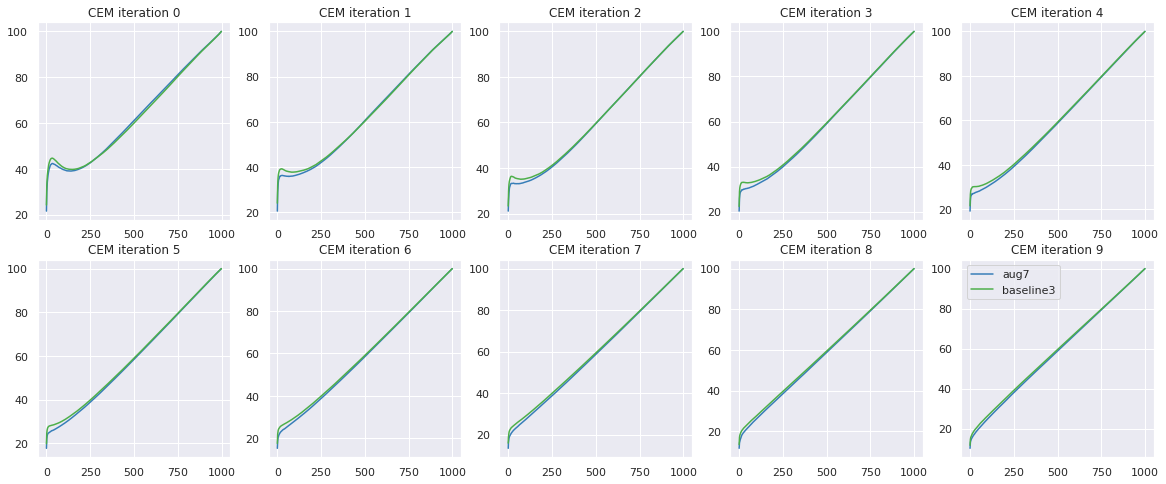

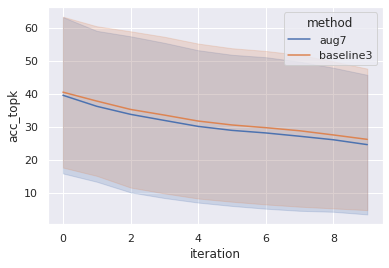

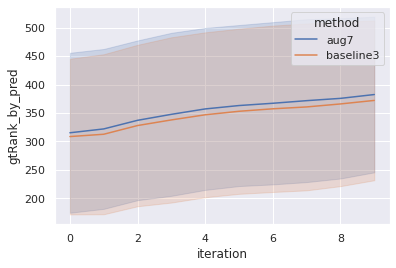

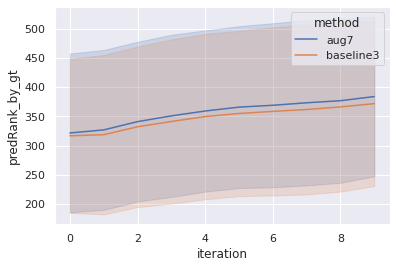

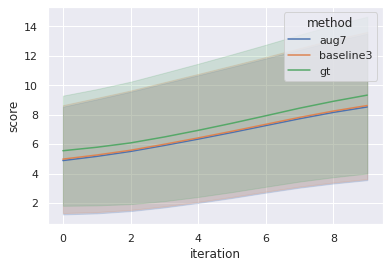

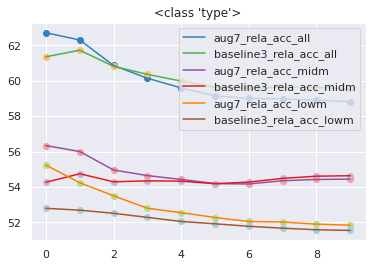

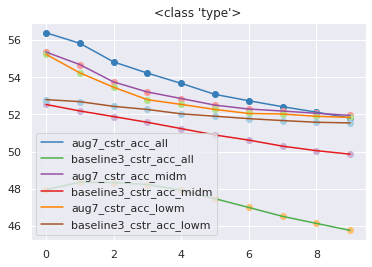

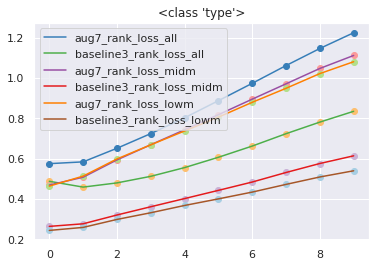

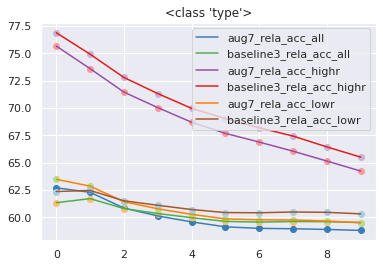

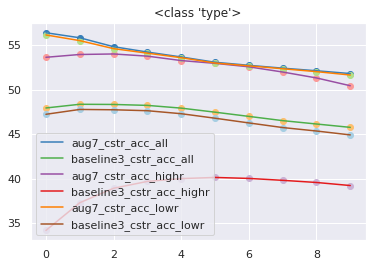

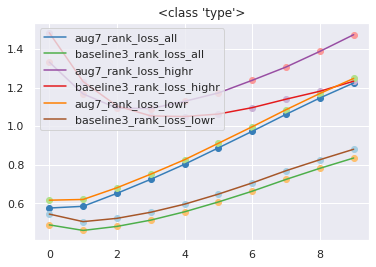

TypeError: list indices must be integers or slices, not tuple

In [18]:
evaluate('finger_spin', 'aug7', 'baseline3')